In [ ]:
!nvidia-smi

In [ ]:
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

In [3]:
!unzip -q "archive.zip"

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
# creating the pathlib Path  objects
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [ ]:
#data path objects have a function called GLOB which iterates the files in directory that matches the given paths

train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

#output is a generator object
print(train_image_paths)

# pathlib's GLOB method returns a generator object #

In [ ]:
# convert generator object to list of elements
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

#now the outputs are "posixpath" objects
print(train_image_paths[:3])


In [ ]:
# convert posix paths to normal strings
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths))
print(train_image_paths [:3])

In [ ]:
#collect the lengths of training and validation datasets just to keep track of it 
train_datasets_length = len(train_image_paths)
val_datasets_length = len(val_image_paths)
print(val_datasets_length)
print(train_datasets_length)

In [ ]:
#every image has a label in its path , so leta slice it 
# this function returns the label of thaty image path after assigning its unique label to it #
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL'  , 1 : 'PNEUMONIA' }

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])


In [11]:
from tensorflow.python.ops.image_ops_impl import random_flip_left_right
#now we have all training , validation image pahs and their respectiv labels 
BATCH_SIZE = 32
#FUNCTION USED FOR TRANSFORM
#image  is the path of the image 
#label which is the label of the image path
#train is boolean which notifies this function weather it is being usid in training or validation
#size 224 is choosen because we are using ResNet 50 whis has input size of 224 only
#if we run this function in training mode we allove for some data augmentation vut we dont alove for validation sets 
#finally we return the tensor and its respective labels 
def load_and_transform(image , label , train=True ):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image , channels = 3)
  image = tf.image.resize(image, [224,224] , method="nearest")
  if train:
    image = tf.image.random_flip_left_right(image)
    return image , label  

In [12]:
# creating a tensor flow data object 
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)
    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset


In [ ]:
#creating a train dataset  object and verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels, train = True)

image, label = next(iter(train_dataset))

print(image.shape)
print(label.shape)

PNEUMONIA


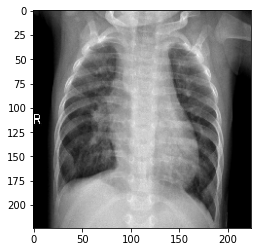

In [14]:
#view sample train image
# we convert  images into numpy array and change thelabels to an underastandable text
print (INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224,224,3))

In [ ]:
#now we test the validation datadet as well once we are clear with it we now go to model generation
#creating a val dataset object and verifying it
%time val_dataset = get_dataset(val_image_paths , val_labels )

image, label = next(iter(val_dataset))

print(image.shape)
print(label.shape) 

PNEUMONIA


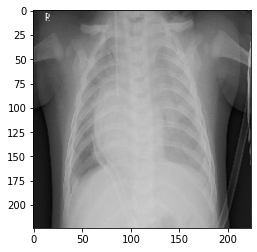

In [16]:
#view sample val image
# we convert  images into numpy array and change thelabels to an underastandable text
print (INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224,224,3))


In [17]:
#Build a resnet model 
#we kepp input_top = false to remobe the final layers
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape = (224,224,3),
    include_top= False
)
#we use tf.keras.Sequential to join multiple tensorflow grafs sequentially first we want the data to flow through backbone 
#this GlobalAveragePooling2D() layer  average all the signals over final layer blocks
#finally we connevt this layer to singel neuron having sigmoid function because this is yes or no problem
model = tf.keras.Sequential([
                    backbone,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(1,activation='sigmoid')
                             ])
model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [18]:
#compling your model by providing the optimiyer ,loss and metrics
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.999,epsilon=1e-07),
    loss = 'binary_crossentropy',
    #because our problem is binary we are using binary_crossentropy 
    #if the problem is multi class then we should use categorical_crossentropy 
    metrics = ['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    # as this is a medical problem  i added precision and recaall to metrics list this are the things we keep track on 
)

In [19]:
# tensor flow callback objects are used to perform an action in various stages of training process.it could be at the start or the end of an epoch or step
# i am going to use Earlystopping  callback it is used to stop the training process before our model tries to over learn the data i.e over fitting
# it takes an argument called patience which is the number of epochs with no improvment
# next call back is model check point this is used to save a model or its weights at a particular frequency
# defining our call backs
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only=True )
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [20]:
from gc import callbacks
#  train the model model.fit function
history = model.fit(
    train_dataset,
    steps_per_epoch = train_datasets_length//BATCH_SIZE,
    epochs=8,
    callbacks = [checkpoint,early_stop],
    validation_data=val_dataset,
    validation_steps = val_datasets_length//BATCH_SIZE,
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9317 - precision: 0.9537 - recall: 0.9614
Epoch 00001: val_loss improved from inf to 44.73046, saving model to best_weights.h5
163/163 [==============================] - 190s 994ms/step - loss: 0.1810 - accuracy: 0.9317 - precision: 0.9537 - recall: 0.9614 - val_loss: 44.7305 - val_accuracy: 0.3750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9553 - precision: 0.9705 - recall: 0.9698
Epoch 00002: val_loss improved from 44.73046 to 9.76632, saving model to best_weights.h5
163/163 [==============================] - 160s 986ms/step - loss: 0.1181 - accuracy: 0.9553 - precision: 0.9705 - recall: 0.9698 - val_loss: 9.7663 - val_accuracy: 0.4030 - val_precision: 1.0000 - val_recall: 0.0294
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9632 - precision: 0.9778 - re

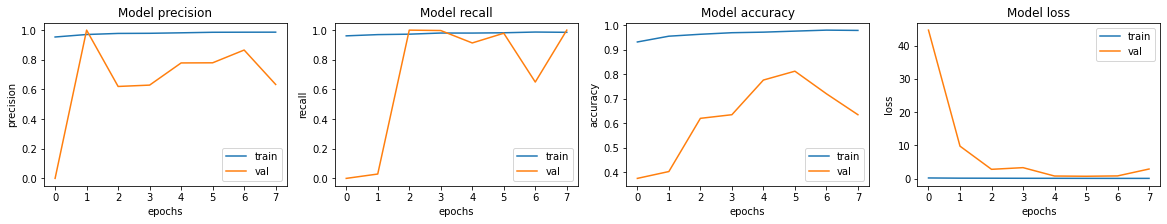

In [22]:
from IPython.core.pylabtools import figsize
#interpreting the metrics
fig, ax = plt.subplots(1,4,figsize=(20,3))
ax= ax.ravel()

for i,met in enumerate (['precision','recall','accuracy','loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+ met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train','val'])

In [24]:
#save the best model
#load the best weights
model.load_weights("best_weights.h5")
#save the whole model (weights + archetecture)
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [26]:
# loading the whole model

loaded_model = tf.keras.models.load_model("model.h5")

**Testing**

In [38]:
from ssl import CHANNEL_BINDING_TYPES
test_image_paths = list(test_path.glob("*/*"))
# convert posix paths to normal strings
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x :  get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image, label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image, [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
     .from_tensor_slices((test_image_paths,test_labels))
     .map(decode_image)
     .batch(BATCH_SIZE)
 )


In [39]:
#VERIFY TEST DATASET OBJECT
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


PNEUMONIA


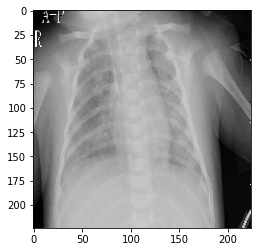

In [40]:
#view a sample validation image
print (INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224,224,3))

In [41]:
#evaluating the loaded model
loss,acc,prec,rec = loaded_model.evaluate(test_dataset)

print("testing acc :" , acc)
print("testing precision :" , prec)
print("testing recall :" , rec)

1/1 [==============================] - 3s 3s/step - loss: 0.1316 - accuracy: 0.9375 - precision: 0.8889 - recall: 1.0000
testing acc : 0.9375
testing precision : 0.8888888955116272
testing recall : 1.0
